In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [11]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [12]:
len(unique_tokens)

2162

In [13]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [14]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [15]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [16]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [17]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [18]:
np.mean([len(i) for i in padded_sentences])

12.0

In [19]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [20]:
images.shape

(3840, 224, 224, 3)

In [21]:
len(class_weights)

2162

In [22]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [23]:
len(class_weights), len(vocab)

(2165, 2165)

In [24]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [25]:
class_weights = np.array(class_weights)

In [26]:
class_weights.shape

(2165,)

# Model with transfer learning

In [27]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [28]:
import tensorflow.keras.applications as apps


In [29]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, trainable=False, n_finetune=5):
        super(ConvEncoder, self).__init__()
        #building resnet
        resnet = apps.ResNet152V2(include_top=False, weights='imagenet')
        outputs = [i for i in resnet.layers if i.name=='conv4_block5_out'][0]
        inputs = resnet.layers[0]
        self.resnet_extractor = tf.keras.models.Model(inputs=inputs.input, outputs=outputs.output)
        if trainable and n_finetune:
            for layer in self.resnet_extractor.layers[:-n_finetune]:
                layer.trainable = False
        else:
            self.resnet_extractor.trainable = trainable
        
        #batch norm
        self.batch_norm1 =  tf.keras.layers.BatchNormalization()
        self.batch_norm2 =  tf.keras.layers.BatchNormalization()
        self.batch_norm3 =  tf.keras.layers.BatchNormalization()
        #dropout
        self.dropout = tf.keras.layers.Dropout(0.1)
        
        #on top extractors 
        self.conv1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=7, activation='relu',
                               padding='same', name='conv1', strides=(2,2))
        self.conv2 = tf.keras.layers.Conv2D(filters=1024, kernel_size=5, activation='relu',
                                       padding='same', name='conv2', strides=(2,2))
        self.conv3 = tf.keras.layers.Conv2D(filters=512, kernel_size=4, activation='relu',
                                       padding='same', name='conv3', strides=(2,2))
        self.conv4 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, activation='relu',
                                       padding='same', name='conv4', strides=(2,2))
        
        self.conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, activation='relu',
                                       padding='same', name='conv5', strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, input):
        resnet_features = self.resnet_extractor(input)
        conv1_out = self.batch_norm1(self.conv1(resnet_features))
        conv2_out = self.batch_norm2(self.conv2(conv1_out))
        conv3_out = self.batch_norm3(self.conv3(conv2_out))
        conv4_out = self.conv4(conv3_out)
        conv5_out = self.conv5(conv3_out)
        return [self.dropout(self.flatten(conv4_out)), self.dropout(self.flatten(conv5_out))]

In [30]:
conv_encoder = ConvEncoder()

In [31]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



### LSTM model

### making w2v embeddings

In [32]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [33]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [34]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [35]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [36]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### building model

In [37]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder', recurrent_dropout=0.3)
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.dropout(self.embeddings(input))
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [38]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1], w2v_embeddings, dim=300)

### Training

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [41]:
epochs = 20
batch_size = 128
patience_epochs = 2

In [42]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [43]:
@tf.function
def train_step(image, target, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [44]:
@tf.function
def evaluate(image, target, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [45]:
train_images, test_images, train_sequences, test_sequences =  train_test_split(images, indexed, test_size=0.1, random_state=10)

In [46]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [47]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [48]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))

In [49]:
train_images.shape, train_sequences.shape, train_length.shape

((27, 128, 224, 224, 3), (27, 128, 12), (27, 128))

In [50]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [51]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [52]:
from tqdm import tqdm

In [53]:
train_loss = []
train_perplexity = []
test_loss = []
test_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_test_loss = 0
    epoch_test_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_test_images, batch_test_sequences, batched_test_length in zip(test_images,test_sequences,test_length):
        batched_test_loss, batched_test_perplexity = evaluate(batch_test_images,batch_test_sequences,batched_test_length, optimizer)
        epoch_test_loss+=batched_test_loss
        epoch_test_perplexity+=batched_test_perplexity
    epoch_test_loss = epoch_test_loss/test_images.shape[0]
    epoch_test_perplexity = epoch_test_perplexity/test_images.shape[0]
    test_perplexity.append(epoch_test_perplexity)
    test_loss.append(epoch_test_loss)
    print('Test loss : {}; Test perplexity : {}'.format(epoch_test_loss,epoch_test_perplexity))
    if len(test_loss)>=2 and test_loss[-2]<test_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in test loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

27it [01:35,  3.52s/it]


Finished epoch 0; Train loss : 6.384143352508545; Train perplexity : 1158.3629150390625


0it [00:00, ?it/s]

Test loss : 5.637437343597412; Test perplexity : 282.3059997558594


27it [01:07,  2.49s/it]


Finished epoch 1; Train loss : 5.321061134338379; Train perplexity : 206.83990478515625


0it [00:00, ?it/s]

Test loss : 5.280252933502197; Test perplexity : 197.35179138183594


27it [01:07,  2.49s/it]


Finished epoch 2; Train loss : 5.018704414367676; Train perplexity : 152.35186767578125


0it [00:00, ?it/s]

Test loss : 5.022033214569092; Test perplexity : 152.22036743164062


27it [01:06,  2.47s/it]


Finished epoch 3; Train loss : 4.736280918121338; Train perplexity : 115.10311126708984


0it [00:00, ?it/s]

Test loss : 4.7516255378723145; Test perplexity : 116.11553955078125


27it [01:06,  2.47s/it]


Finished epoch 4; Train loss : 4.374888896942139; Train perplexity : 80.20204162597656


0it [00:00, ?it/s]

Test loss : 4.4608941078186035; Test perplexity : 86.77053833007812


27it [01:06,  2.47s/it]


Finished epoch 5; Train loss : 4.075833320617676; Train perplexity : 59.503780364990234


0it [00:00, ?it/s]

Test loss : 4.281620979309082; Test perplexity : 72.54279327392578


27it [01:06,  2.47s/it]


Finished epoch 6; Train loss : 3.846888542175293; Train perplexity : 47.23488998413086


0it [00:00, ?it/s]

Test loss : 4.125515460968018; Test perplexity : 62.029083251953125


27it [01:06,  2.47s/it]


Finished epoch 7; Train loss : 3.6530520915985107; Train perplexity : 38.87377166748047


0it [00:00, ?it/s]

Test loss : 3.9650166034698486; Test perplexity : 52.842350006103516


27it [01:06,  2.47s/it]


Finished epoch 8; Train loss : 3.492928981781006; Train perplexity : 33.147457122802734


0it [00:00, ?it/s]

Test loss : 3.885286331176758; Test perplexity : 48.78471755981445


27it [01:06,  2.47s/it]


Finished epoch 9; Train loss : 3.342580795288086; Train perplexity : 28.505064010620117


0it [00:00, ?it/s]

Test loss : 3.8556454181671143; Test perplexity : 47.3289794921875


27it [01:06,  2.47s/it]


Finished epoch 10; Train loss : 3.202863931655884; Train perplexity : 24.787118911743164


0it [00:00, ?it/s]

Test loss : 3.748364210128784; Test perplexity : 42.53842544555664


27it [01:06,  2.47s/it]


Finished epoch 11; Train loss : 3.0731096267700195; Train perplexity : 21.761558532714844


0it [00:00, ?it/s]

Test loss : 3.705522298812866; Test perplexity : 40.741981506347656


27it [01:06,  2.48s/it]


Finished epoch 12; Train loss : 2.943540334701538; Train perplexity : 19.11166763305664


0it [00:00, ?it/s]

Test loss : 3.6962945461273193; Test perplexity : 40.371089935302734


27it [01:06,  2.47s/it]


Finished epoch 13; Train loss : 2.826796054840088; Train perplexity : 17.019893646240234


0it [00:00, ?it/s]

Test loss : 3.657137632369995; Test perplexity : 38.81162643432617


27it [01:06,  2.48s/it]


Finished epoch 14; Train loss : 2.6904447078704834; Train perplexity : 14.830857276916504


0it [00:00, ?it/s]

Test loss : 3.6778953075408936; Test perplexity : 39.65049743652344


27it [01:06,  2.48s/it]


Finished epoch 15; Train loss : 2.5708887577056885; Train perplexity : 13.152482986450195


0it [00:00, ?it/s]

Test loss : 3.6640713214874268; Test perplexity : 39.06524658203125


27it [01:06,  2.47s/it]


Finished epoch 16; Train loss : 2.44234037399292; Train perplexity : 11.55751895904541


0it [00:00, ?it/s]

Test loss : 3.6092748641967773; Test perplexity : 36.9858512878418


27it [01:06,  2.48s/it]


Finished epoch 17; Train loss : 2.325941324234009; Train perplexity : 10.305183410644531


0it [00:00, ?it/s]

Test loss : 3.6294071674346924; Test perplexity : 37.743194580078125


27it [01:06,  2.48s/it]


Finished epoch 18; Train loss : 2.1935513019561768; Train perplexity : 9.0056791305542


0it [00:00, ?it/s]

Test loss : 3.628310203552246; Test perplexity : 37.717342376708984


27it [01:06,  2.47s/it]


Finished epoch 19; Train loss : 2.076371192932129; Train perplexity : 8.014264106750488
Test loss : 3.7644708156585693; Test perplexity : 43.24824523925781


# Viewing and saving results

In [54]:
df = pd.DataFrame()
model_name = 'conv_lstm_transfer_learning_w2v_resnet_fixed_size'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['test_perplexity'] = [i.numpy() for i in test_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['test_loss'] = [i.numpy() for i in test_loss]


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

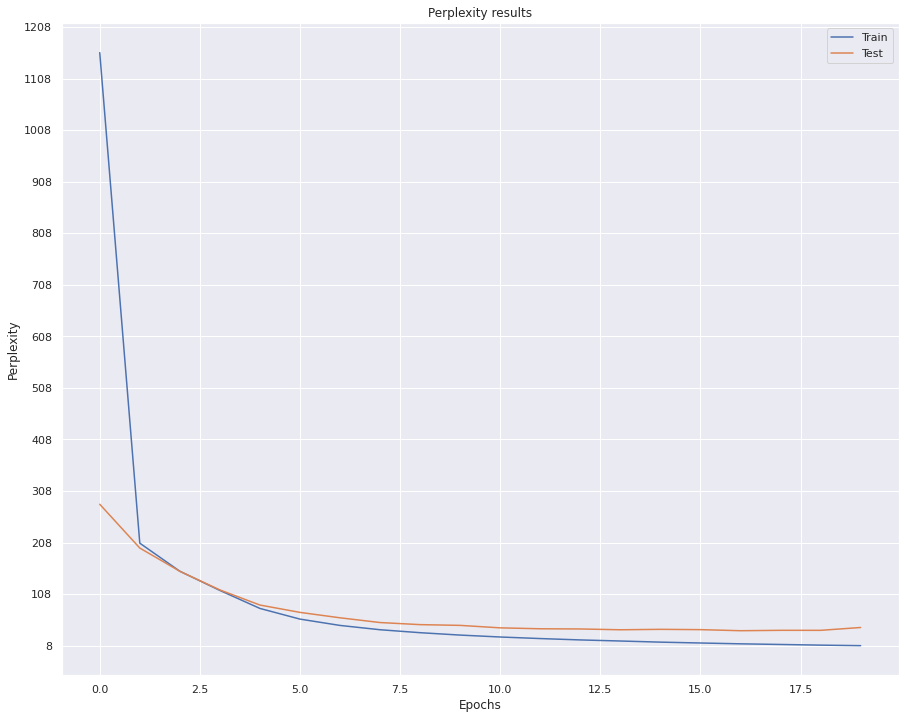

In [56]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['test_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Test']);

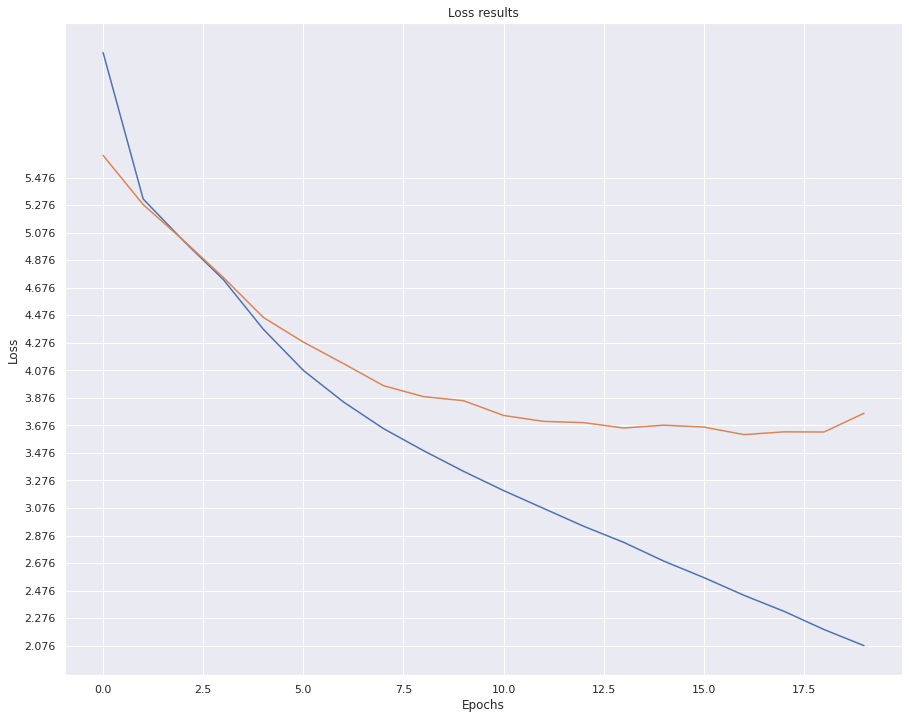

In [57]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['test_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['test_loss']),0.2));

# Testing model

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input):
        initial_state = self.encoder(np.expand_dims(input, axis=0))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [60]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state = self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [61]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [62]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10)

In [63]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10)

In [64]:
images.shape

(3840, 224, 224, 3)

In [161]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

two men are happy to watch game together


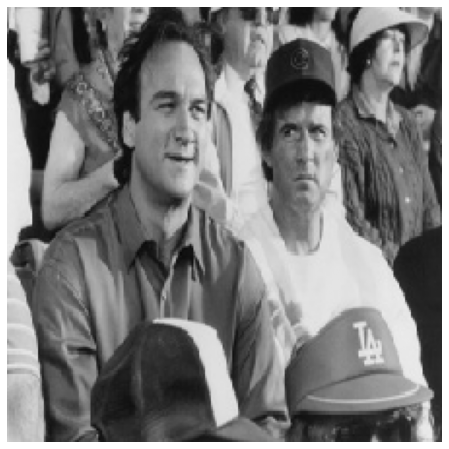

In [162]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [163]:
predict(sample, greedy_decoder, inverse_vocab)

'two woman is happy to see each other'

In [164]:
predict(sample, beam_decoder, inverse_vocab, beam_size=3)

'two woman is laughing at something'

In [165]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

'two men are laughing at something'

In [166]:
predict(sample, beam_decoder, inverse_vocab, beam_size=7)

'the woman is flirting with the woman'

In [167]:
predict(sample, beam_decoder, inverse_vocab, beam_size=10)

'the woman is flirting with the woman'

# Blue score calculation

In [168]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [169]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 3/3 [04:00<00:00, 80.31s/it]


In [170]:
test_predictions = [i.split(' ') for i in test_predictions]

In [171]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [172]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [173]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.025676984779944335


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [174]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.24945970732395936


In [175]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.09629564731172403


In [176]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.04343158558562079


In [177]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.02142439421454574


In [178]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.025676984779944335


In [179]:
df.head()

,train_perplexity,test_perplexity,train_loss,test_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,1158.362915,282.306000,6.384143,5.637437,2.567698,24.945971,9.629565,4.343159,2.142439,2.567698
1,206.839905,197.351791,5.321061,5.280253,2.567698,24.945971,9.629565,4.343159,2.142439,2.567698
2,152.351868,152.220367,5.018704,5.022033,2.567698,24.945971,9.629565,4.343159,2.142439,2.567698
3,115.103111,116.115540,4.736281,4.751626,2.567698,24.945971,9.629565,4.343159,2.142439,2.567698
4,80.202042,86.770538,4.374889,4.460894,2.567698,24.945971,9.629565,4.343159,2.142439,2.567698


In [180]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [181]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [182]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))

# Predictions on own data

In [193]:
img = np.array(im.load_img('hospital-birth.jpg', target_size=(224,224)))/255

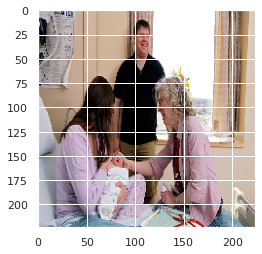

In [194]:
plt.imshow(img)

In [195]:
predict(img, greedy_decoder, inverse_vocab)

'man is arguing with the woman'

In [196]:
predict(img, beam_decoder, inverse_vocab, beam_size=3)

'a man is trying to shoot somebody'

In [197]:
predict(img, beam_decoder, inverse_vocab, beam_size=5)

'the man is arguing with the woman'

In [198]:
predict(img, beam_decoder, inverse_vocab, beam_size=7)

'man is trying to shoot somebody'

In [199]:
predict(img, beam_decoder, inverse_vocab, beam_size=10)

'man is flirting with the woman'